# Libaray

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

from transformers import AutoTokenizer, AutoModel

from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter  # TensorBoard
import os

C:\Users\Parth\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  #output with 2 labels as speciied
        )

    def forward(self, x):
        return self.model(x)

# Example input size (to be updated based on feature extraction method)
input_size = 10000  #based on the provided model architecture. 

# Initialize model
mlp_model_ = MLPClassifier(input_size)
print(mlp_model_)

# Count trainable parameters
print("\n\n############### Parameters ############### ")
total_params = sum(p.numel() for p in mlp_model_.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")


MLPClassifier(
  (model): Sequential(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)


############### Parameters ############### 
Total Trainable Parameters: 5293122


# For the bert embedding

## Loading Saved Embeddings

In [3]:
import numpy as np
import torch

# Load training embeddings and labels
X_train_imdb_bert = np.load("saved_bert_embed_imdb/IMDB_train_BERT_embeddings.npy")
y_train_imdb = np.load("saved_bert_embed_imdb/IMDB_train_labels.npy")

# Load validation embeddings and labels
X_val_imdb_bert = np.load("saved_bert_embed_imdb/IMDB_val_BERT_embeddings.npy")
y_val_imdb = np.load("saved_bert_embed_imdb/IMDB_val_labels.npy")

# Convert to PyTorch tensors
X_train_imdb_bert = torch.tensor(X_train_imdb_bert, dtype=torch.float32)
y_train_imdb = torch.tensor(y_train_imdb, dtype=torch.long)

X_val_imdb_bert = torch.tensor(X_val_imdb_bert, dtype=torch.float32)
y_val_imdb = torch.tensor(y_val_imdb, dtype=torch.long)

print(f"Train Tensor Shape: {X_train_imdb_bert.shape}")
print(f"Validation Tensor Shape: {X_val_imdb_bert.shape}")


Train Tensor Shape: torch.Size([40000, 768])
Validation Tensor Shape: torch.Size([10000, 768])


In [4]:
# Create DataLoaders
train_dataset = TensorDataset(X_train_imdb_bert, y_train_imdb)
val_dataset = TensorDataset(X_val_imdb_bert, y_val_imdb)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"IMDB BERT Training Features Shape: {X_train_imdb_bert.shape}")
print(f"IMDB BERT Validation Features Shape: {X_val_imdb_bert.shape}")


IMDB BERT Training Features Shape: torch.Size([40000, 768])
IMDB BERT Validation Features Shape: torch.Size([10000, 768])


In [5]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
input_size = X_train_imdb_bert.shape[1]  # Set input size dynamically
model = MLPClassifier(input_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# DataLoader for training & validation
batch_size = 32
train_dataset = TensorDataset(X_train_imdb_bert, y_train_imdb)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_imdb_bert, y_val_imdb)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Setup TensorBoard
log_dir = "logs/imdb_bert"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model.eval()
    correct = 0
    total = 0
    val_loss = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total

    # Log losses & accuracy to TensorBoard
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)
    writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

writer.close()
print("Training complete! ")

# Save the trained model
torch.save(model.state_dict(), "saved_models_bert/MLP_BERT_Final.pt")
print("Model saved successfully!")

# Run TensorBoard (use this command in terminal)
# tensorboard --logdir=logs/imdb_bert

Epoch [1/10] | Train Loss: 0.3262 | Val Loss: 0.3004 | Val Acc: 0.8634
Epoch [2/10] | Train Loss: 0.2891 | Val Loss: 0.2923 | Val Acc: 0.8805
Epoch [3/10] | Train Loss: 0.2799 | Val Loss: 0.2840 | Val Acc: 0.8860
Epoch [4/10] | Train Loss: 0.2735 | Val Loss: 0.2652 | Val Acc: 0.8898
Epoch [5/10] | Train Loss: 0.2680 | Val Loss: 0.2648 | Val Acc: 0.8883
Epoch [6/10] | Train Loss: 0.2625 | Val Loss: 0.2666 | Val Acc: 0.8882
Epoch [7/10] | Train Loss: 0.2574 | Val Loss: 0.2728 | Val Acc: 0.8839
Epoch [8/10] | Train Loss: 0.2537 | Val Loss: 0.2614 | Val Acc: 0.8904
Epoch [9/10] | Train Loss: 0.2480 | Val Loss: 0.2693 | Val Acc: 0.8844
Epoch [10/10] | Train Loss: 0.2432 | Val Loss: 0.2710 | Val Acc: 0.8794
Training complete! 
Model saved successfully!


# For bag of wordds

In [8]:
# Load the IMDB dataset
imdb_url = "https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv"
imdb_df = pd.read_csv(imdb_url)

# Convert sentiment to numerical labels ('positive' -> 1, 'negative' -> 0)
imdb_df['label'] = imdb_df['sentiment'].apply(lambda x: 1 if x.lower() == 'positive' else 0)

# Split dataset (80% training, 20% validation)
imdb_train_df, imdb_val_df = train_test_split(imdb_df, test_size=0.2, random_state=42)

# Extract text and labels
imdb_train_texts = imdb_train_df['review']
imdb_train_labels = imdb_train_df['label']
imdb_val_texts = imdb_val_df['review']
imdb_val_labels = imdb_val_df['label']

# Initialize CountVectorizer for Bag-of-Words representation
vectorizer = CountVectorizer(max_features=10000)  # Limit vocabulary size to 10,000
X_train_imdb = vectorizer.fit_transform(imdb_train_texts).toarray()
X_val_imdb = vectorizer.transform(imdb_val_texts).toarray()

# Convert features and labels to PyTorch tensors
X_train_imdb_bow = torch.tensor(X_train_imdb, dtype=torch.float32)
X_val_imdb_bow = torch.tensor(X_val_imdb, dtype=torch.float32)
y_train_imdb = torch.tensor(imdb_train_labels.values, dtype=torch.long)
y_val_imdb = torch.tensor(imdb_val_labels.values, dtype=torch.long)

print(f"IMDB BoW Training Features Shape: {X_train_imdb.shape}")
print(f"IMDB BoW Validation Features Shape: {X_val_imdb.shape}")


IMDB BoW Training Features Shape: (40000, 10000)
IMDB BoW Validation Features Shape: (10000, 10000)


In [9]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
input_size = X_train_imdb_bow.shape[1]  # Set input size dynamically
model = MLPClassifier(input_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# DataLoader for training & validation
batch_size = 32
train_dataset = TensorDataset(X_train_imdb_bow, y_train_imdb)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_imdb_bow, y_val_imdb)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Setup TensorBoard
log_dir = "logs/imdb_bow"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model.eval()
    correct = 0
    total = 0
    val_loss = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total

    # Log losses & accuracy to TensorBoard
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)
    writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

writer.close()
print("Training complete! 🎉")

# Save the trained model
torch.save(model.state_dict(), "saved_models_bow/MLP_BoW_Final.pt")
print("Model saved successfully!")

# Run TensorBoard (use this command in terminal)
# tensorboard --logdir=logs/imdb_bow

Epoch [1/10] | Train Loss: 0.3153 | Val Loss: 0.2515 | Val Acc: 0.8947
Epoch [2/10] | Train Loss: 0.1882 | Val Loss: 0.3161 | Val Acc: 0.8854
Epoch [3/10] | Train Loss: 0.1037 | Val Loss: 0.3358 | Val Acc: 0.8898
Epoch [4/10] | Train Loss: 0.0403 | Val Loss: 0.5710 | Val Acc: 0.8856
Epoch [5/10] | Train Loss: 0.0176 | Val Loss: 0.8382 | Val Acc: 0.8837
Epoch [6/10] | Train Loss: 0.0162 | Val Loss: 0.9806 | Val Acc: 0.8866
Epoch [7/10] | Train Loss: 0.0128 | Val Loss: 0.7697 | Val Acc: 0.8875
Epoch [8/10] | Train Loss: 0.0115 | Val Loss: 0.7699 | Val Acc: 0.8874
Epoch [9/10] | Train Loss: 0.0109 | Val Loss: 0.6217 | Val Acc: 0.8872
Epoch [10/10] | Train Loss: 0.0140 | Val Loss: 0.7819 | Val Acc: 0.8875
Training complete! 🎉
Model saved successfully!


C:\Users\Parth\AppData\Local\Temp\ipykernel_29104\1307470804.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=t

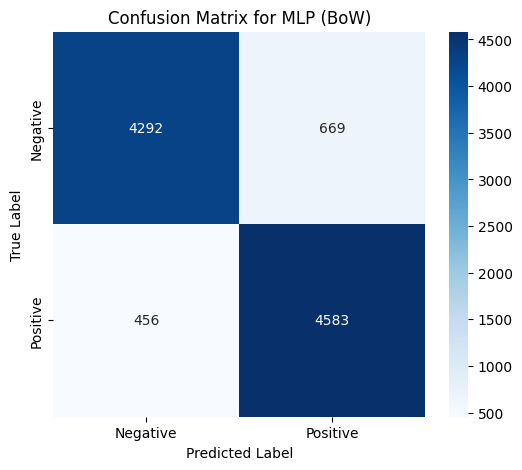


Classification Report for MLP (BoW):
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      4961
           1       0.87      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



C:\Users\Parth\AppData\Local\Temp\ipykernel_29104\1307470804.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=t

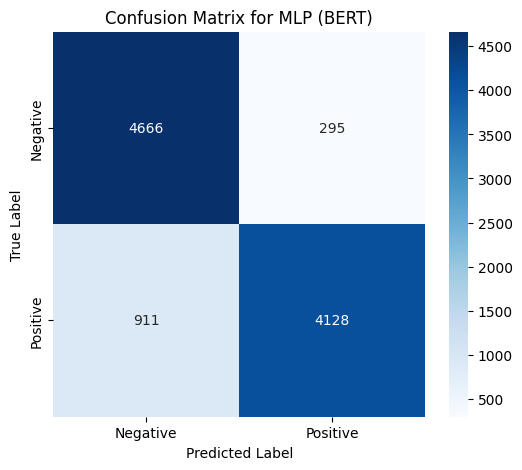


Classification Report for MLP (BERT):
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      4961
           1       0.93      0.82      0.87      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



In [13]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report



# Define function to load model and compute predictions
def evaluate_model(model_path, X_val, model_name="Model"):
    # Load model
    input_size = X_val.shape[1]
    model = MLPClassifier(input_size)
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    model.eval()

    # Convert to tensor
    X_val = torch.tensor(X_val, dtype=torch.float32)

    # Get predictions
    with torch.no_grad():
        outputs = model(X_val)
        predictions = torch.argmax(outputs, dim=1).numpy()

    # Compute confusion matrix
    cm = confusion_matrix(y_val_imdb.numpy(), predictions)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    # Print classification report
    print(f"\nClassification Report for {model_name}:\n", classification_report(y_val_imdb.numpy(), predictions))



# Evaluate BoW Model
evaluate_model("saved_models_bow/MLP_BoW_Final.pt", X_val_imdb_bow, "MLP (BoW)")

# Evaluate BERT Model
evaluate_model("saved_models_bert/MLP_BERT_Final.pt", X_val_imdb_bert, "MLP (BERT)")


In [10]:
!tensorboard --logdir=logs/imdb_bert

^C
